In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from common.pickle_utils import load_from_pickle
from common.const import SUBSETS
from common.model_utils import model_sort_key
from evaluate.run_eval import stats_filepath, stat_df_index_name


def get_model_family(model):
    return model_sort_key(stat_df_index_name(model, "base"))[0]


def get_model_type(model):
    if get_model_family(model) in ["Gemini", "Claude", "Deepseek"]:
        return "Proprietary"

    if "_sft" in model:
        return "Open Small SFT"

    param_size = model_sort_key(stat_df_index_name(model, "base"))[1]
    if param_size < 10:
        return "Open Small Base"
    elif param_size < 100:
        return "Open Medium"
    else:
        return "Open Large"


def load_df(subset):
    df = load_from_pickle(stats_filepath(subset, "test"))
    df = df.reset_index()
    df = df.rename(columns={"index": "model"})

    df["family"] = df["model"].apply(lambda x: get_model_family(x))
    df["type"] = df["model"].apply(lambda x: get_model_type(x))
    return df

Loading Data from './output/general-knowledge/stat/original_test.pkl'
Loading Data from './output/math-reasoning/stat/original_test.pkl'


<Figure size 1000x600 with 0 Axes>

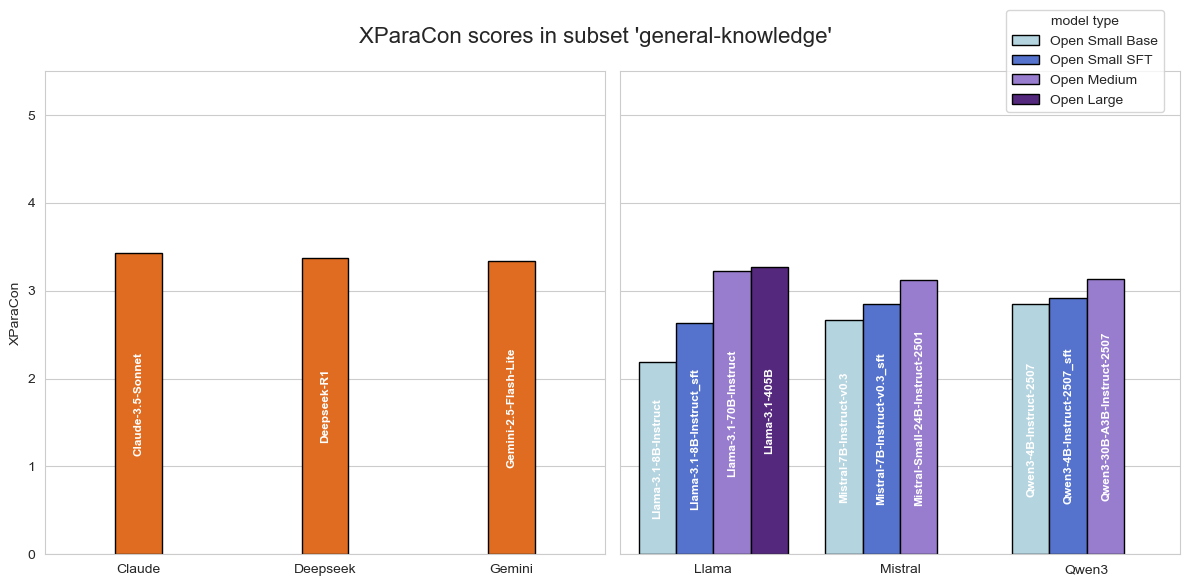

<Figure size 1000x600 with 0 Axes>

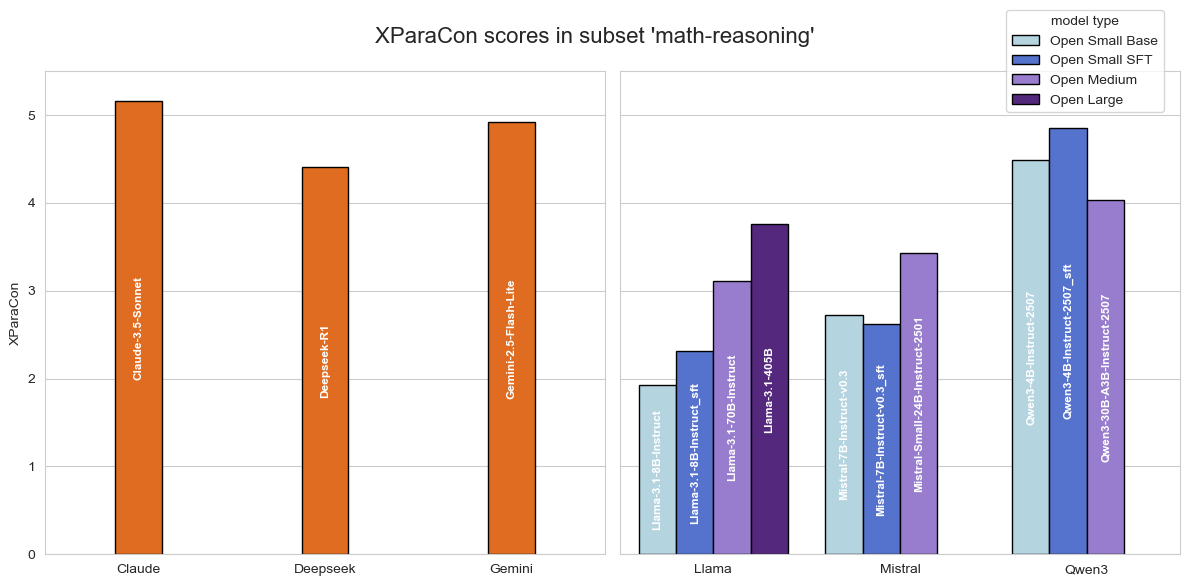

In [8]:
def save_xparacon_barplot(subset):
    df = load_df(subset)

    # Create the Plot
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    custom_palette = {
        "Proprietary": "#FF6600",
        "Open Small Base": "#ADD8E6",
        "Open Small SFT": "#4169E1",
        "Open Medium": "#9370DB",
        "Open Large": "#551A8B",
    }

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    def annotate_bars(ax):
        """Adds model name text inside each bar"""
        for idx, container in enumerate(ax.containers):
            if len(ax.containers) == 1:
                model_type = "Proprietary"
            else:
                model_type = list(custom_palette.keys())[idx + 1]

            # Filter the input DataFrame for the current type
            df_hue = df[df["type"] == model_type].sort_values("family")

            # Iterate through the bars in the container
            for i, bar in enumerate(container):
                # Retrieve the model name from the filtered data row
                model_name = df_hue.iloc[i]["model"]
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height * 0.5,
                    model_name,
                    ha="center",
                    va="center",
                    rotation=90,
                    color="white",
                    fontweight="bold",
                    fontsize=8.5,
                )

    # Create barplot
    sns.barplot(
        data=df[df["type"] == "Proprietary"],
        x="family",
        y="xparacon",
        hue="type",
        palette=custom_palette,
        ax=axes[0],
        edgecolor="black",
        width=0.25,
    )
    annotate_bars(axes[0])

    sns.barplot(
        data=df[df["type"] != "Proprietary"],
        x="family",
        y="xparacon",
        hue="type",
        palette=custom_palette,
        ax=axes[1],
        edgecolor="black",
    )
    annotate_bars(axes[1])

    for ax in axes:
        ax.set_ylim(0, 5.5)
        ax.get_legend().remove()
        ax.set_xlabel("")
        ax.set_ylabel("XParaCon")

    # Place a single, unified legend
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="model type",
        loc="upper right",
        bbox_to_anchor=(0.98, 0.98),
    )

    # Adjust layout
    plt.suptitle(f"XParaCon scores in subset '{subset}'", y=0.94, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make space for the title
    # plt.show()
    plt.savefig(f"./output/{subset}/figure/xparacon_barplot.png")


for subset in SUBSETS:
    save_xparacon_barplot(subset)

Loading Data from './output/general-knowledge/stat/original_test.pkl'
Loading Data from './output/math-reasoning/stat/original_test.pkl'


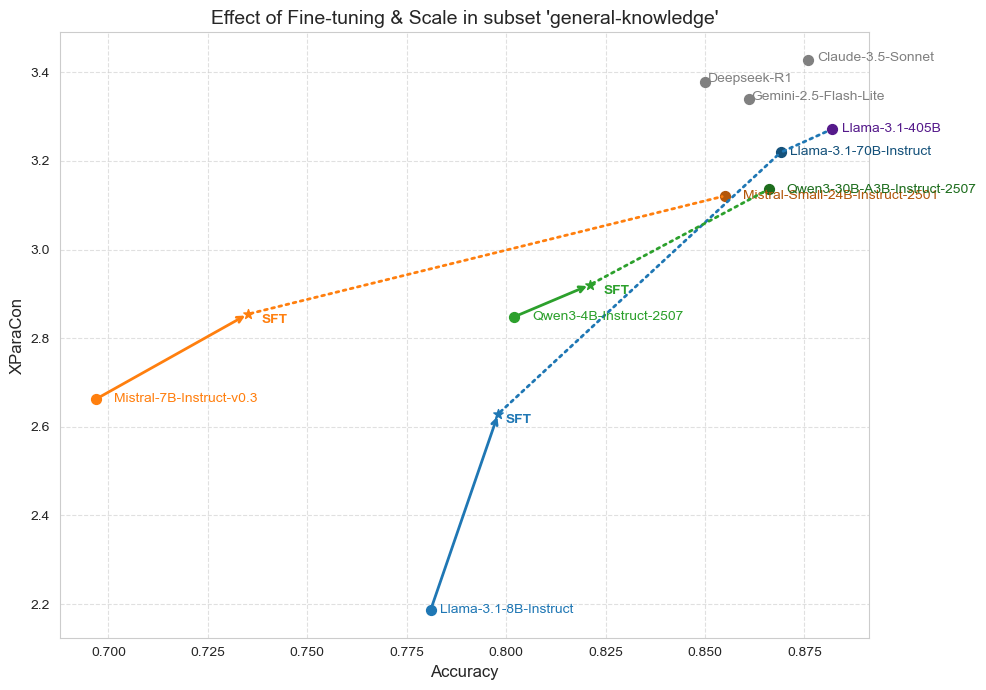

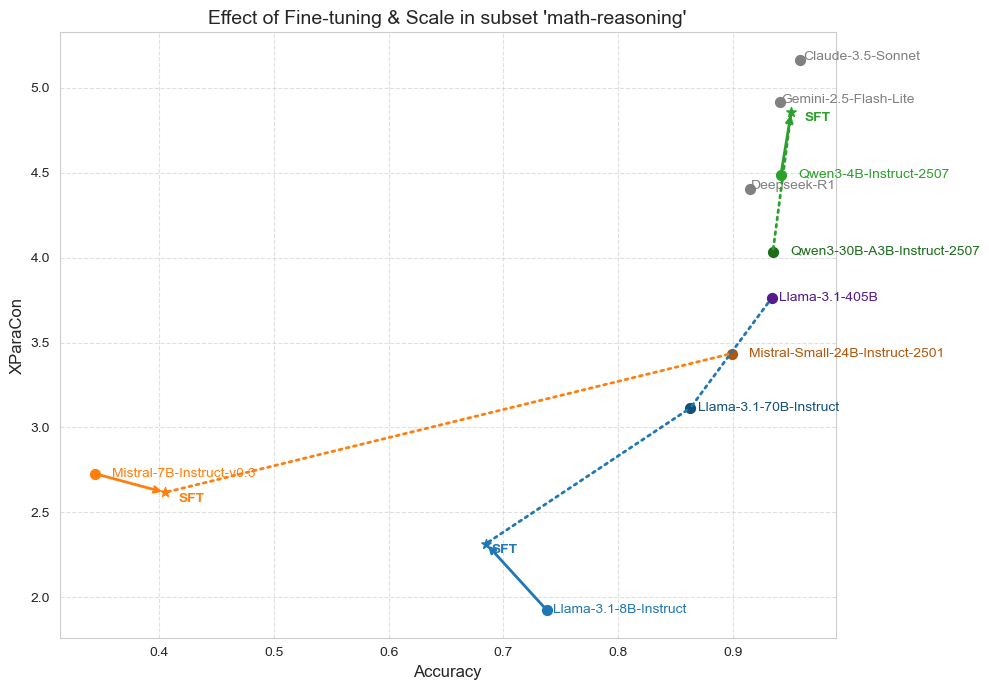

In [9]:
def save_2d_scatter_plot(subset):
    df = load_df(subset)

    plt.figure(figsize=(10, 7))
    plt.grid(True, linestyle="--", alpha=0.6)

    def add_model_label(row, color):
        label_name = "SFT" if "_sft" in row["model"] else row["model"]
        delta = (0.017, -0.015) if "_sft" in row["model"] else (0.022, -0.005)
        xlimits = plt.xlim()
        ylimits = plt.ylim()

        fontweight = "bold" if "_sft" in row["model"] else "medium"
        plt.text(
            row["accuracy"] + delta[0] * (xlimits[1] - xlimits[0]),
            row["xparacon"] + delta[1] * (ylimits[1] - ylimits[0]),
            label_name,
            fontsize=10,
            color=color,
            fontweight=fontweight,
        )

    def add_scatter_and_label(row, color, marker="o"):
        plt.scatter(row["accuracy"], row["xparacon"], color=color, s=50, marker=marker)
        add_model_label(row, color)

    # Plot Proprietary
    proprietary_df = df[df["type"] == "Proprietary"]
    for _, row in proprietary_df.iterrows():
        add_scatter_and_label(row, "grey")

    # Plot Open Source
    small_colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green
    medium_colors = ["#14517A", "#B3570A", "#1D6D1D"]
    
    for i, family in enumerate(["Llama", "Mistral", "Qwen3"]):
        small_base = df[
            (df["family"] == family) & (df["type"] == "Open Small Base")
        ].iloc[0]
        small_sft = df[
            (df["family"] == family) & (df["type"] == "Open Small SFT")
        ].iloc[0]
        medium = df[(df["family"] == family) & (df["type"] == "Open Medium")].iloc[0]

        # Plot points and labels
        add_scatter_and_label(small_base, small_colors[i])
        add_scatter_and_label(small_sft, small_colors[i], marker="*")
        add_scatter_and_label(medium, medium_colors[i])

        # Draw Arrows & Lines
        plt.annotate(
            "",
            xy=(small_sft["accuracy"], small_sft["xparacon"]),
            xytext=(small_base["accuracy"], small_base["xparacon"]),
            arrowprops=dict(arrowstyle="->", color=small_colors[i], lw=2),
        )
        plt.annotate(
            "",
            xy=(medium["accuracy"], medium["xparacon"]),
            xytext=(small_sft["accuracy"], small_sft["xparacon"]),
            arrowprops=dict(arrowstyle="-", linestyle=":", color=small_colors[i], lw=2),
        )

        # add Llama-3.1-405B (large)
        if family == "Llama":
            large = df[(df["family"] == family) & (df["type"] == "Open Large")].iloc[0]
            add_scatter_and_label(large, "#551A8B")
            plt.annotate(
                "",
                xy=(large["accuracy"], large["xparacon"]),
                xytext=(medium["accuracy"], medium["xparacon"]),
                arrowprops=dict(
                    arrowstyle="-", linestyle=":", color=small_colors[i], lw=2
                ),
            )

    plt.title(
        f"Effect of Fine-tuning & Scale in subset '{subset}'",
        fontsize=14,
    )
    plt.xlabel("Accuracy", fontsize=12)
    plt.ylabel("XParaCon", fontsize=12)
    
    plt.tight_layout()
    # plt.show()
    plt.savefig(f"./output/{subset}/figure/2d_scatter_plot.png")


for subset in SUBSETS:
    save_2d_scatter_plot(subset)